In [1]:
!nvidia-smi

Sun Jun 30 08:33:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 2  # binary classification (fracture vs. non-fracture)
EPOCHS = 20
LEARNING_RATE = 0.0001

# Set the paths
MODEL_SAVE_PATH = '/content/drive/MyDrive/defense/new inception/model.h5'
MODEL_HISTORY_CSV_PATH = '/content/drive/MyDrive/defense/new inception/model_history.csv'
train_dir = '/content/drive/MyDrive/defense/brone fracture train test val/train'
validation_dir = '/content/drive/MyDrive/defense/brone fracture train test val/val'
test_dir = '/content/drive/MyDrive/defense/brone fracture train test val/test'

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load pre-trained InceptionV3 model
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Add custom classification head with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Reduced to 256 units
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Reduced to 128 units
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune the last few layers of the base model
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(MODEL_HISTORY_CSV_PATH)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Reduced patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)  # Reduced patience

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, early_stopping, reduce_lr]
)

# Save the overall CSV file
history_df = pd.DataFrame(history.history)
history_df.to_csv(MODEL_HISTORY_CSV_PATH, index=False)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // BATCH_SIZE)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the model
model.save(MODEL_SAVE_PATH)


Found 6664 images belonging to 2 classes.
Found 946 images belonging to 2 classes.
Found 1893 images belonging to 2 classes.
87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/20
208/208 [==============================] - ETA: 0s - loss: 6.1059 - accuracy: 0.6331

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


208/208 [==============================] - 2418s 11s/step - loss: 6.1059 - accuracy: 0.6331 - val_loss: 5.1617 - val_accuracy: 0.7759 - lr: 1.0000e-04
Epoch 2/20
208/208 [==============================] - 127s 609ms/step - loss: 4.5864 - accuracy: 0.7506 - val_loss: 3.8411 - val_accuracy: 0.8631 - lr: 1.0000e-04
Epoch 3/20
208/208 [==============================] - 124s 596ms/step - loss: 3.4258 - accuracy: 0.8023 - val_loss: 2.8450 - val_accuracy: 0.8901 - lr: 1.0000e-04
Epoch 4/20
208/208 [==============================] - 121s 581ms/step - loss: 2.5782 - accuracy: 0.8429 - val_loss: 2.1093 - val_accuracy: 0.9149 - lr: 1.0000e-04
Epoch 5/20
208/208 [==============================] - 120s 577ms/step - loss: 1.9560 - accuracy: 0.8629 - val_loss: 1.5872 - val_accuracy: 0.9213 - lr: 1.0000e-04
Epoch 6/20
208/208 [==============================] - 126s 608ms/step - loss: 1.5011 - accuracy: 0.8795 - val_loss: 1.1768 - val_accuracy: 0.9558 - lr: 1.0000e-04
Epoch 7/20
208/208 [==============

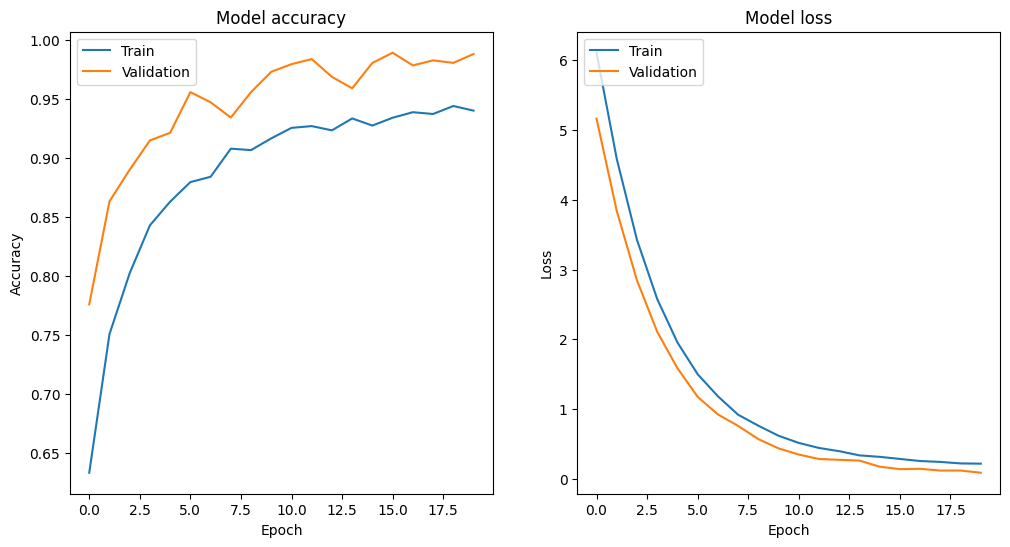

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
history_df = pd.read_csv('/content/drive/MyDrive/defense/new inception/model_history.csv')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Found 1893 images belonging to 2 classes.
60/60 [==============================] - 11s 154ms/step


<Figure size 1000x700 with 0 Axes>

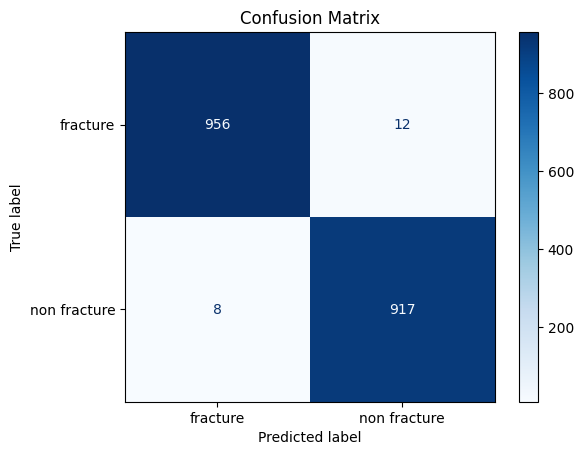

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Set the paths
MODEL_SAVE_PATH = '/content/drive/MyDrive/defense/new inception/model.h5'
test_dir = '/content/drive/MyDrive/defense/brone fracture train test val/test'

# Load the model
model = load_model(MODEL_SAVE_PATH)

# Data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Get the ground truth labels
true_labels = test_generator.classes

# Predict the labels for the test set
predictions = model.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
predicted_labels = np.round(predictions).astype(int).reshape(-1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Set the paths
MODEL_SAVE_PATH = '/content/drive/MyDrive/defense/new inception/model.h5'
test_dir = '/content/drive/MyDrive/defense/brone fracture train test val/test'

# Load the model
model = load_model(MODEL_SAVE_PATH)

# Data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Get the ground truth labels
true_labels = test_generator.classes

# Predict the labels for the test set
predictions = model.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
predicted_labels = np.round(predictions).astype(int).reshape(-1)

# Print classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print(report)


Found 1893 images belonging to 2 classes.
60/60 [==============================] - 11s 161ms/step
              precision    recall  f1-score   support

    fracture       0.99      0.99      0.99       968
non fracture       0.99      0.99      0.99       925

    accuracy                           0.99      1893
   macro avg       0.99      0.99      0.99      1893
weighted avg       0.99      0.99      0.99      1893



Found 1893 images belonging to 2 classes.
60/60 [==============================] - 11s 162ms/step


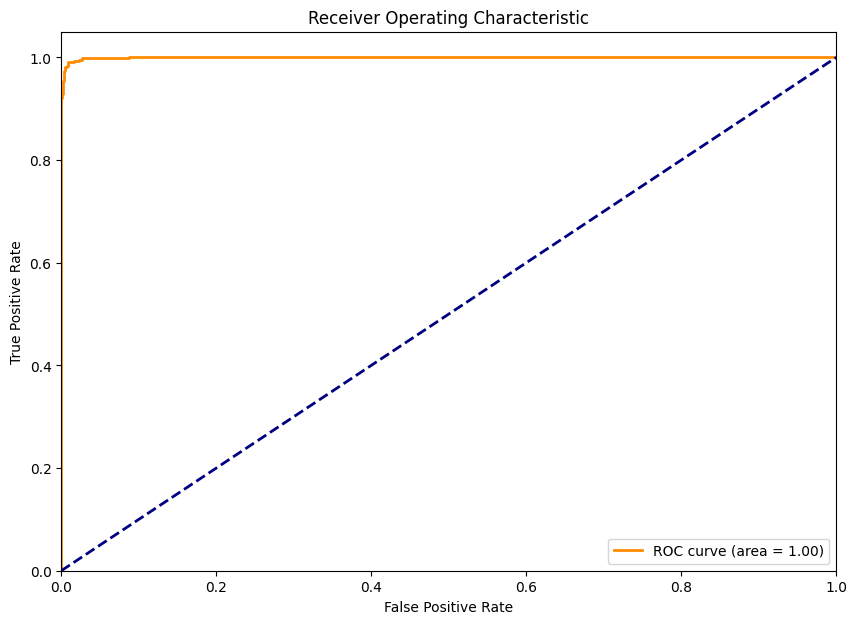

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Set the paths
MODEL_SAVE_PATH = '/content/drive/MyDrive/defense/new inception/model.h5'
test_dir = '/content/drive/MyDrive/defense/brone fracture train test val/test'

# Load the model
model = load_model(MODEL_SAVE_PATH)

# Data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Get the ground truth labels
true_labels = test_generator.classes

# Predict the labels for the test set
predictions = model.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
predicted_probabilities = predictions.ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Found 1893 images belonging to 2 classes.
60/60 [==============================] - 11s 158ms/step
AUC score: 0.9994695108331472


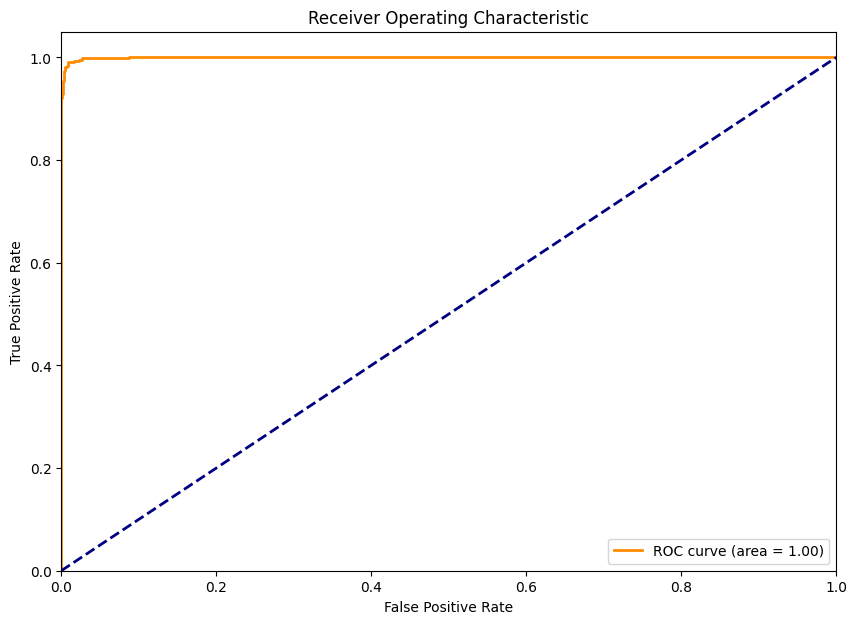

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Set the paths
MODEL_SAVE_PATH = '/content/drive/MyDrive/defense/new inception/model.h5'
test_dir = '/content/drive/MyDrive/defense/brone fracture train test val/test'

# Load the model
model = load_model(MODEL_SAVE_PATH)

# Data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Get the ground truth labels
true_labels = test_generator.classes

# Predict the labels for the test set
predictions = model.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
predicted_probabilities = predictions.ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Print AUC score
print('AUC score:', roc_auc)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
